# Problem

<div style="border-radius:12px;  border:2px solid blue; padding: 15px; background-color: #f6f5f5; font-size:120%; text-align:left">
    
- The main aim of the competition is to use our training data to predict **`sii`** or **`Severity Impairment Index`**, which is a standard measure of Problematic Internet Use (PIU).
- The training data comprises 3,960 records of children and young people with 81 columns (not including the ID column).
- Of particular importance in the data are results of the **`Parent-Child Internet Addiction Test (PCIAT)`**.

# <p style="padding:15px; background-color:#81BFDA; font-family:arial; font-weight:bold; color:white; font-size:100%; letter-spacing: 2px; text-align:left; border-radius: 10px 10px"> I. Import necessary libraries and Read data from input files</p>

In [340]:
import numpy as np, pandas as pd, os
import seaborn as sns
from sklearn.model_selection import cross_val_score, StratifiedKFold
import xgboost as xgb
import plotly.express as px, seaborn as sns, matplotlib.pyplot as plt
sns.set_style('darkgrid')
from sklearn.metrics import make_scorer, cohen_kappa_score
import eli5
from eli5.sklearn import PermutationImportance
import warnings
warnings.simplefilter('ignore')

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [341]:
train_df = pd.read_csv("/kaggle/input/child-mind-institute-problematic-internet-use/train.csv")
test_df = pd.read_csv("/kaggle/input/child-mind-institute-problematic-internet-use/test.csv")
sample = pd.read_csv("/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv")

# <p style="padding:15px; background-color:#81BFDA; font-family:arial; font-weight:bold; color:white; font-size:100%; letter-spacing: 2px; text-align:left; border-radius: 10px 10px">II. Exploratory Data Analysis</p>

In [342]:
train_df.head()

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,...,4.0,2.0,4.0,55.0,NaN,NaN,NaN,Fall,3.0,2.0
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,...,0.0,0.0,0.0,0.0,Fall,46.0,64.0,Summer,0.0,0.0
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,...,2.0,1.0,1.0,28.0,Fall,38.0,54.0,Summer,2.0,0.0
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,...,3.0,4.0,1.0,44.0,Summer,31.0,45.0,Winter,0.0,1.0
4,0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Data Type Transformation

- Transform different data types into Numerical(float, int), Categorical or String.

In [343]:
def convert_dtype(df, cols, dtype):
    for col in cols:
        if col in df.columns:
            df[col] = df[col].astype(dtype)

In [344]:
float_cols = ["Basic_Demos-Age","Physical-BMI","Physical-Height","Physical-Weight","FGC-FGC_GSND","FGC-FGC_GSD","FGC-FGC_SRL","FGC-FGC_SRR","BIA-BIA_BMC",
           "BIA-BIA_BMI","BIA-BIA_BMR","BIA-BIA_DEE","BIA-BIA_ECW","BIA-BIA_FFM","BIA-BIA_FFMI","BIA-BIA_FMI","BIA-BIA_Fat","BIA-BIA_ICW","BIA-BIA_LDM",
           "BIA-BIA_LST","BIA-BIA_SMM","BIA-BIA_TBW","PAQ_A-PAQ_A_Total","PAQ_C-PAQ_C_Total","CGAS-CGAS_Score","Physical-Waist_Circumference","Physical-Diastolic_BP",
           "Physical-HeartRate","Physical-Systolic_BP","Fitness_Endurance-Max_Stage","Fitness_Endurance-Time_Mins","Fitness_Endurance-Time_Sec","FGC-FGC_CU","FGC-FGC_PU",
           "FGC-FGC_TL","PCIAT-PCIAT_Total","SDS-SDS_Total_Raw","SDS-SDS_Total_T"]

category_cols = ["Basic_Demos-Sex","FGC-FGC_CU_Zone","FGC-FGC_GSND_Zone","FGC-FGC_GSD_Zone","FGC-FGC_PU_Zone","FGC-FGC_SRL_Zone","FGC-FGC_SRR_Zone","FGC-FGC_TL_Zone",
            "BIA-BIA_Activity_Level_num","BIA-BIA_Frame_num","PCIAT-PCIAT_01","PCIAT-PCIAT_02","PCIAT-PCIAT_03","PCIAT-PCIAT_04","PCIAT-PCIAT_05","PCIAT-PCIAT_06",
            "PCIAT-PCIAT_07","PCIAT-PCIAT_08","PCIAT-PCIAT_09","PCIAT-PCIAT_10","PCIAT-PCIAT_11","PCIAT-PCIAT_12","PCIAT-PCIAT_13","PCIAT-PCIAT_14","PCIAT-PCIAT_15",
            "PCIAT-PCIAT_16","PCIAT-PCIAT_17","PCIAT-PCIAT_18","PCIAT-PCIAT_19","PCIAT-PCIAT_20",
            "Basic_Demos-Enroll_Season","CGAS-Season","Physical-Season","Fitness_Endurance-Season","FGC-Season","BIA-Season","PAQ_A-Season","PAQ_C-Season","PCIAT-Season","SDS-Season","PreInt_EduHx-Season","PreInt_EduHx-computerinternet_hoursday"]

string_cols = ["id"]

convert_dtype(train_df, float_cols, 'float64')
convert_dtype(train_df, category_cols, 'category')
convert_dtype(train_df, string_cols, 'string')

convert_dtype(test_df, float_cols, 'float64')
convert_dtype(test_df, category_cols, 'category')
convert_dtype(test_df, string_cols, 'string')

train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3960 entries, 0 to 3959
Data columns (total 82 columns):
 #   Column                                  Non-Null Count  Dtype   
---  ------                                  --------------  -----   
 0   id                                      3960 non-null   string  
 1   Basic_Demos-Enroll_Season               3960 non-null   category
 2   Basic_Demos-Age                         3960 non-null   float64 
 3   Basic_Demos-Sex                         3960 non-null   category
 4   CGAS-Season                             2555 non-null   category
 5   CGAS-CGAS_Score                         2421 non-null   float64 
 6   Physical-Season                         3310 non-null   category
 7   Physical-BMI                            3022 non-null   float64 
 8   Physical-Height                         3027 non-null   float64 
 9   Physical-Weight                         3076 non-null   float64 
 10  Physical-Waist_Circumference            898 non-

## Evaluation of Fields containing missing values

In [345]:
# Display missing function
def display_missing(df, feature_cols):
    n_rows = df.shape[0]
    for col in feature_cols:
        if col in df.columns:
            missing_count = df[col].isnull().sum()
            if missing_count > 0:
                print(f"{col} has {missing_count} missing values, {missing_count*100/n_rows:.2f}% missing percentage.")

In [346]:
n_rows = train_df["id"].shape[0]

# Calculating the number of missing values and the missing percentage for each column
missing_data = train_df.isnull().sum()

# Calculating the missing percentage 
missing_percentage = (missing_data / len(train_df)) * 100
missing_percentage = missing_percentage.round(2)

# Create a DataFrame describing all the missing values
missing_df = pd.DataFrame({
    'Feature': missing_data.index,
    'Missing Count': missing_data.values,
    'Missing Percentage (%)': missing_percentage.values
})

styled_df = missing_df.style.background_gradient(subset=['Missing Count','Missing Percentage (%)'], cmap='YlOrRd')
styled_df.format({'Missing Percentage (%)': '{:.2f}%'})

,Feature,Missing Count,Missing Percentage (%)
0,id,0,0.00%
1,Basic_Demos-Enroll_Season,0,0.00%
2,Basic_Demos-Age,0,0.00%
3,Basic_Demos-Sex,0,0.00%
4,CGAS-Season,1405,35.48%
5,CGAS-CGAS_Score,1539,38.86%
6,Physical-Season,650,16.41%
7,Physical-BMI,938,23.69%
8,Physical-Height,933,23.56%
9,Physical-Weight,884,22.32%


**Note:** *A greate number of columns having missing values percentage larger than 50%*

## Detailed Analysis

In [347]:
def calculate_stats(data, columns):
    if isinstance(columns, str):
        columns = [columns]

    stats = []
    for col in columns:
        if data[col].dtype in ['object', 'category']:
            counts = data[col].value_counts(dropna=False, sort=False)
            percents = data[col].value_counts(normalize=True, dropna=False, sort=False) * 100
            formatted = counts.astype(str) + ' (' + percents.round(2).astype(str) + '%)'
            stats_col = pd.DataFrame({'count (%)': formatted})
            stats.append(stats_col)
        else:
            stats_col = data[col].describe().to_frame().transpose()
            stats_col['missing'] = data[col].isnull().sum()
            stats_col.index.name = col
            stats.append(stats_col)

    return pd.concat(stats, axis=0)


train_cols = set(train_df.columns)
test_cols = set(test_df.columns)
columns_not_in_test = sorted(list(train_cols - test_cols))

### 1. Analyzing the relationship between`sii` and `PCIAT-PCIAT_Total`

#### General Description
- Field `sii` is described as a standard measure of problematic internet use, which is divided into 4 categories:

  `0` : `None`
  
  `1` : `Mild`
  
  `2` : `Moderate`
  
  `3` : `Severe`

- `PCIAT-PCIAT_Total`: 20-item scale that measures characteristics and behaviors associated with compulsive use of the Internet including compulsivity, escapism, and dependency. Each question has 5 selections ranged from 1 to 5 to demonstrate the frequency of different behaviors.

    

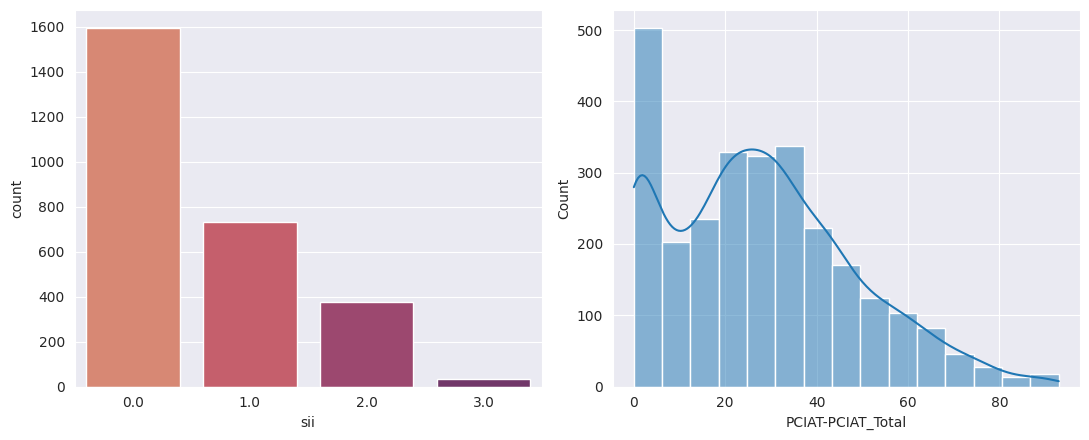

,proportion
sii,
0.0,0.582602
1.0,0.266813
2.0,0.138158
3.0,0.012427


In [348]:
fig, ax = plt.subplots(1, 2, figsize = (2 * 5.5, 1 * 4.5))
sns.countplot(data=train_df, x='sii', palette='flare', ax=ax[0])
sns.histplot(data=train_df, x='PCIAT-PCIAT_Total', bins=15, kde=True, palette='flare', ax=ax[1])

plt.tight_layout()
plt.show()

train_df["sii"].value_counts(normalize = True).to_frame()


**Note:** *By observing the chart, we can tell that the distribution of `sii` is uneven as there is 14% for the value '2' and only 1.2% for value '3'*

#### The relationship between 2 fields

- Index `sii` is derived from `PICAT-PCIAT_Total` with 4 levels:

    Severity Impairment Index: 0-30 = `None`; 31-49 = `Mild`; 50-79 = `Moderate`; 80-100 = `Severe`

- Let's create a function converting `PICAT-PCIAT_Total` to `sii` and evaluate the correlation between 2 fields.

In [349]:
def pciat_to_sii(pciat_total):
    # Applying conditions to classify the SII index
    if pciat_total <= 30:
        return 0
    elif 30 < pciat_total < 50:
        return 1
    elif 50 <= pciat_total < 80:
        return 2
    elif pciat_total >= 80:
        return 3

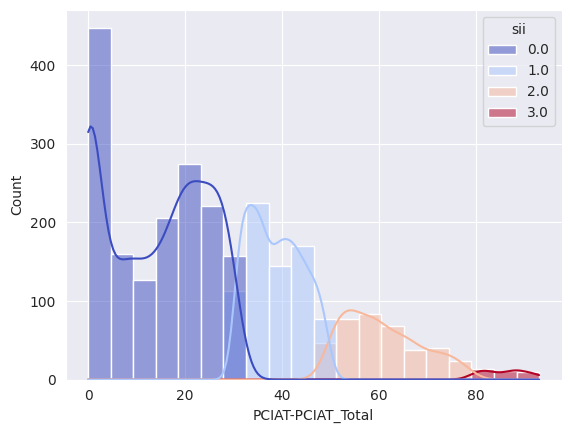

PCIAT-PCIAT_Total has 1224 missing values, 30.91% missing percentage.
sii has 1224 missing values, 30.91% missing percentage.


In [350]:
sns.histplot(data=train_df, x='PCIAT-PCIAT_Total', hue='sii', bins=20, kde=True, palette='coolwarm')
plt.show()

display_missing(train_df, ['PCIAT-PCIAT_Total', 'sii'])

In [351]:
## Analyzing the difference
condition_null = train_df[(train_df['sii'].isnull() & ~train_df['PCIAT-PCIAT_Total'].isnull()) | \
                 (~train_df['sii'].isnull() & train_df['PCIAT-PCIAT_Total'].isnull())]


condition_convert = train_df[~train_df['sii'].isnull() & ~train_df['PCIAT-PCIAT_Total'].isnull() & \
                    (train_df['sii'] != train_df['PCIAT-PCIAT_Total'].apply(pciat_to_sii))]
print("DIFFERENCE")
print(f"Null: {condition_null.shape[0]}")
print(f"Convert: {condition_convert.shape[0]}")

DIFFERENCE
Null: 0
Convert: 0


**Note:** Witnessing the difference of the number of missing values, we can infer the equivalence of missing data between `sii` and `PCIAT-PCIAT_Total`. In addition, converting `PCIAT-PCIAT_Total` to `sii` has no problems.

  **Therefore, we can conclude that 2 fields `PCIAT-PCIAT_Total` and `sii` are completely equivalent and they both play a significant role in training ML models**.

### 2. Age

In [352]:
train_df['Age Group'] = pd.cut(
    train_df['Basic_Demos-Age'],
    bins=[4, 12, 18, 22],
    labels=['Children (5-12)', 'Adolescents (13-18)', 'Adults (19-22)']
)
calculate_stats(train_df, 'Age Group')

,count (%)
Age Group,
Children (5-12),2919 (73.71%)
Adolescents (13-18),953 (24.07%)
Adults (19-22),88 (2.22%)


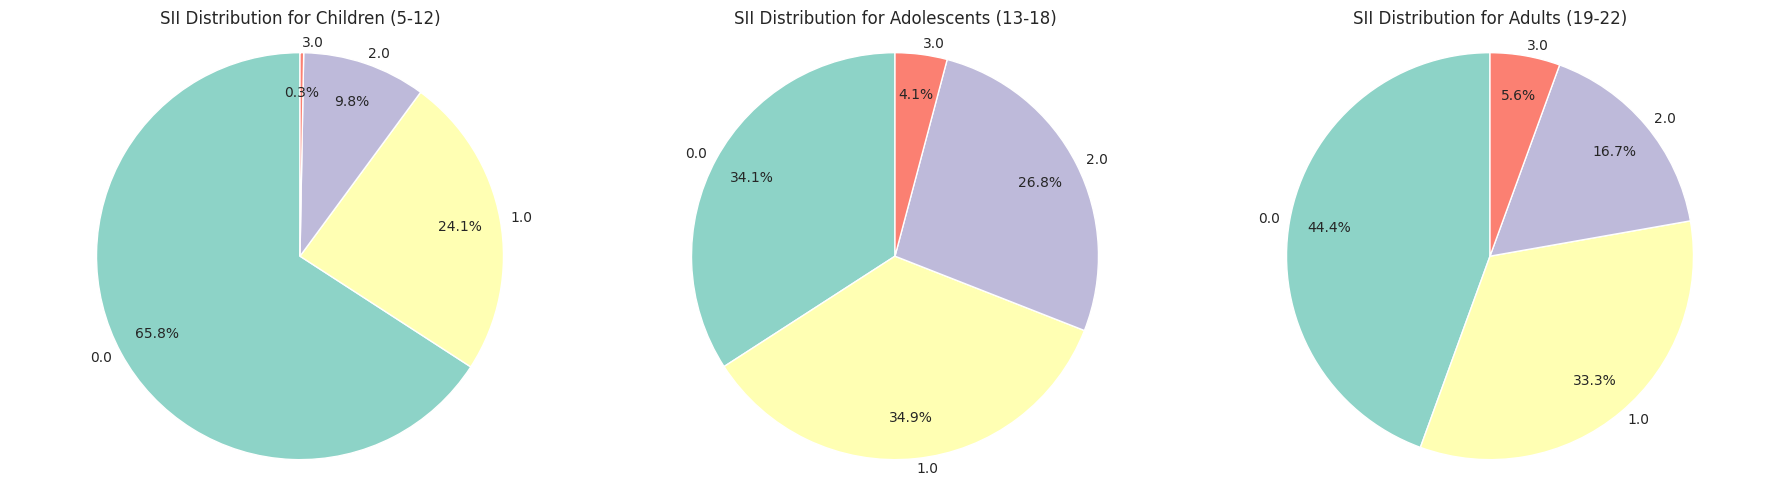

In [353]:
stats = train_df.groupby(['Age Group', 'sii'], observed=False).size().unstack(fill_value=0)
fig, axes = plt.subplots(1, len(stats), figsize=(18, 5))

for i, age_group in enumerate(stats.index):
    group_counts = stats.loc[age_group] / stats.loc[age_group].sum()
    axes[i].pie(
        group_counts, labels=group_counts.index, autopct='%1.1f%%',
        startangle=90, colors=sns.color_palette("Set3"),
        labeldistance=1.05, pctdistance=0.80
    )
    axes[i].set_title(f'SII Distribution for {age_group}')
    axes[i].axis('equal')

plt.tight_layout()
plt.show()

### 3. GCAS-CGAS_Score

- The charts illustrate the distribution of the Severe Impairment Index across three age groups, indicating that this level increases proportionally with the growth of the age groups.

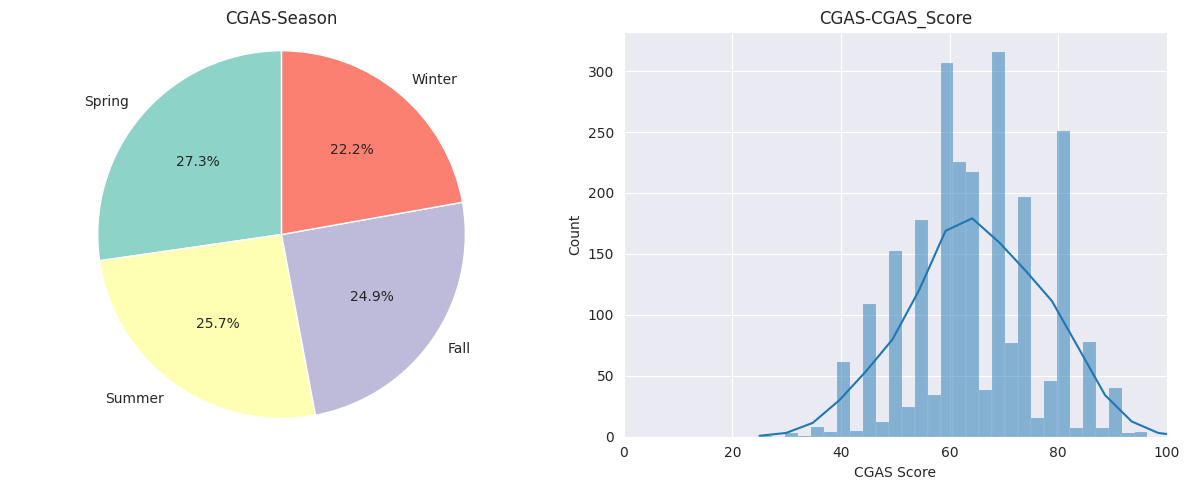

In [354]:
plt.figure(figsize=(12, 5))

# CGAS-Season
plt.subplot(1, 2, 1)
cgas_season_counts = train_df['CGAS-Season'].value_counts(normalize=True)
plt.pie(
    cgas_season_counts, 
    labels=cgas_season_counts.index, 
    autopct='%1.1f%%', 
    startangle=90, 
    colors=sns.color_palette("Set3")
)
plt.title('CGAS-Season')
plt.axis('equal')

# CGAS-CGAS_Score without outliers (score == 999)
plt.subplot(1, 2, 2)
sns.histplot(
    train_df['CGAS-CGAS_Score'].dropna(),
     kde=True
)
plt.title('CGAS-CGAS_Score')
plt.xlabel('CGAS Score')
plt.ylabel('Count')
plt.xlim(0, 100)

plt.tight_layout()
plt.show()

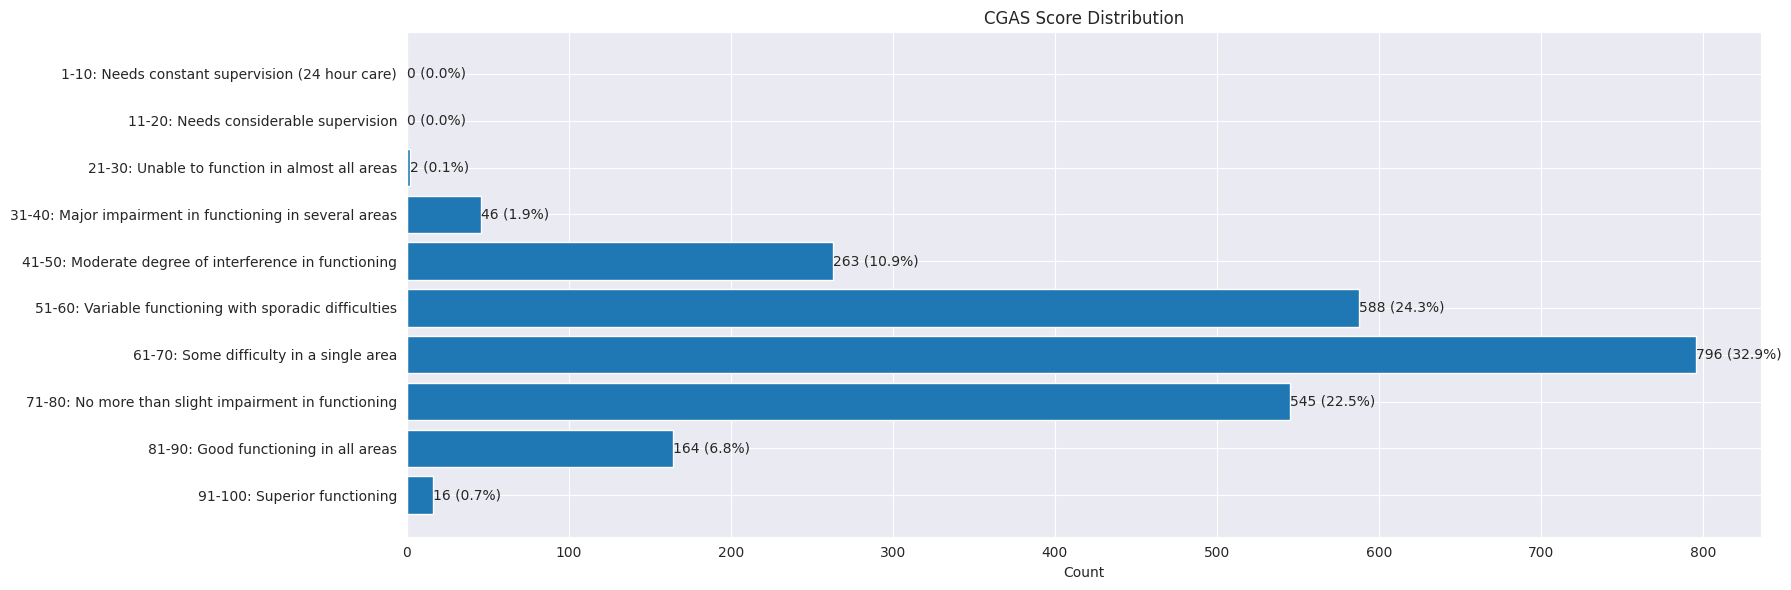

In [355]:
bins = np.arange(0, 101, 10)
labels = [
    "1-10: Needs constant supervision (24 hour care)",
    "11-20: Needs considerable supervision",
    "21-30: Unable to function in almost all areas",
    "31-40: Major impairment in functioning in several areas",
    "41-50: Moderate degree of interference in functioning",
    "51-60: Variable functioning with sporadic difficulties",
    "61-70: Some difficulty in a single area",
    "71-80: No more than slight impairment in functioning",
    "81-90: Good functioning in all areas",
    "91-100: Superior functioning"
]

train_df['CGAS_Score_Bin'] = pd.cut(
    train_df['CGAS-CGAS_Score'], bins=bins, labels=labels
)

counts = train_df['CGAS_Score_Bin'].value_counts().reindex(labels)
prop = (counts / counts.sum() * 100).round(1)
count_prop_labels = counts.astype(str) + " (" + prop.astype(str) + "%)"

plt.figure(figsize=(18, 6))
bars = plt.barh(labels, counts)
plt.xlabel('Count')
plt.title('CGAS Score Distribution')
for bar, label in zip(bars, count_prop_labels):
    plt.text(
        bar.get_width(), bar.get_y() + bar.get_height() / 2, label, va='center'
    )

plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [356]:
calculate_stats(train_df, 'CGAS-CGAS_Score')

,count,mean,std,min,25%,50%,75%,max,missing
CGAS-CGAS_Score,,,,,,,,,
CGAS-CGAS_Score,2421.0,65.454771,22.341862,25.0,59.0,65.0,75.0,999.0,1539


- The charts shows that the distribution of `CGAS-CGAS_Score` ranges mainly from 50 to 80, indicating that the psychological state of children is quite good. However, there are still a few cases whose score are below 50 which should not be ignored.
**Note:** *A number of values don't range from 0 to 100 need readjusting*

### 4. Physic

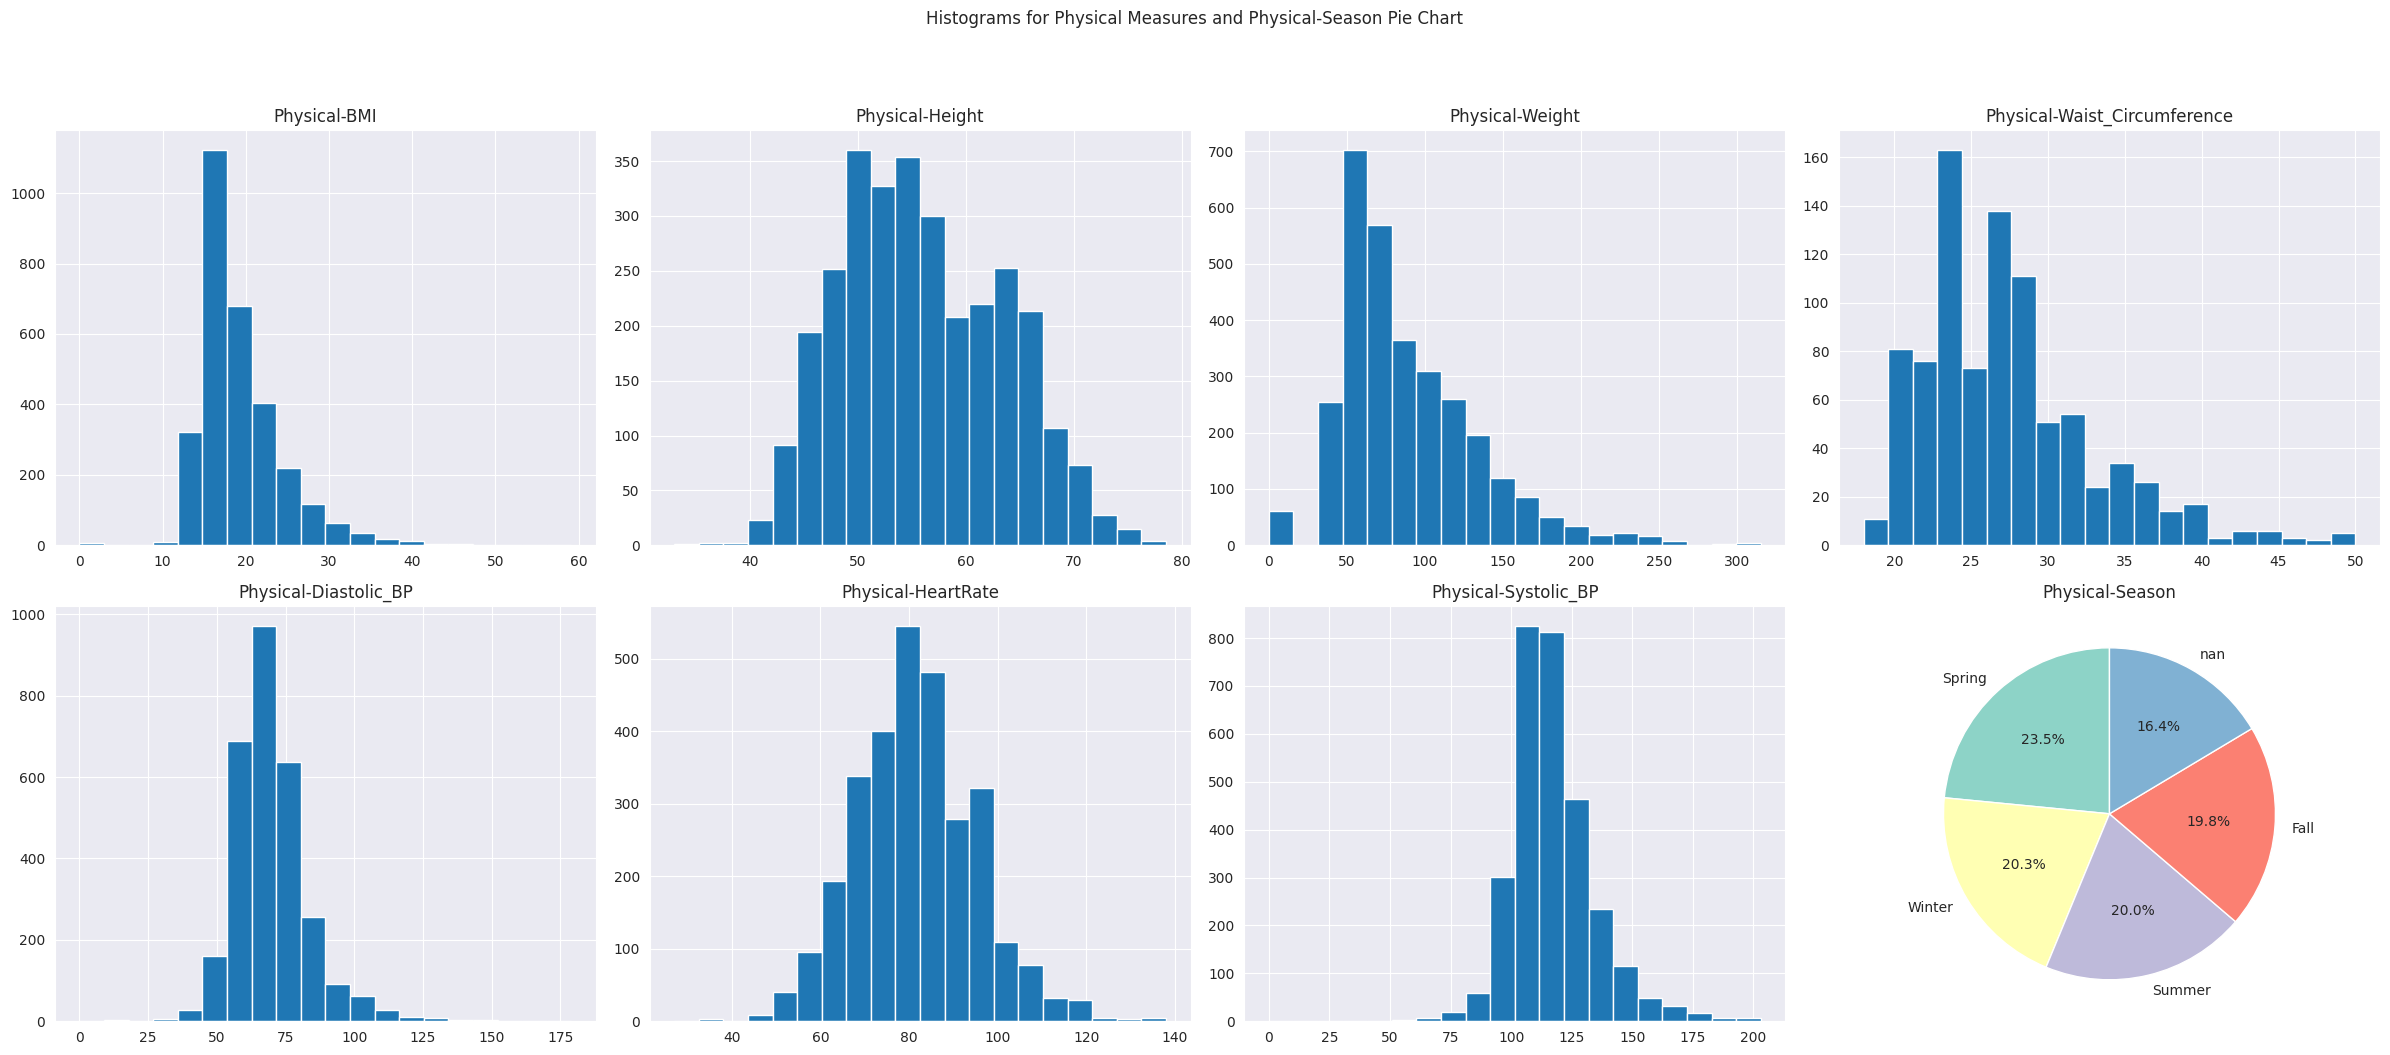

In [357]:
features_physical = [
    "Physical-BMI","Physical-Height","Physical-Weight",
    "Physical-Waist_Circumference", "Physical-Diastolic_BP","Physical-HeartRate","Physical-Systolic_BP", 
    "Physical-Season"
]

cols = [
    "Physical-BMI","Physical-Height","Physical-Weight",
    "Physical-Waist_Circumference", "Physical-Diastolic_BP","Physical-HeartRate","Physical-Systolic_BP", 
]

plt.figure(figsize=(24, 10))
n_cols = 4
n_rows = len(cols) // n_cols + 1

for i, col in enumerate(cols):
    plt.subplot(n_rows, n_cols, i + 1)
    train_df[col].hist(bins=20)
    plt.title(col)

plt.subplot(n_rows, n_cols, len(cols) + 1)
season_counts = train_df['Physical-Season'].value_counts(dropna=False)
plt.pie(
    season_counts,
    labels=season_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=sns.color_palette("Set3")
)
plt.title('Physical-Season')

plt.suptitle('Histograms for Physical Measures and Physical-Season Pie Chart', y=1.05)
plt.tight_layout()
plt.show()

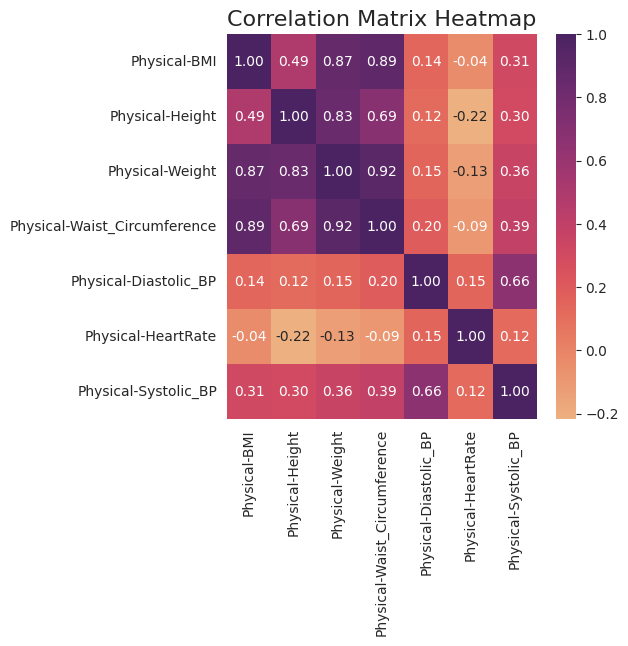

In [358]:
correlation_matrix = train_df[cols].corr()

plt.figure(figsize=(5, 5))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='flare', cbar=True)
plt.title(f"Correlation Matrix Heatmap", fontsize=16)
plt.show()

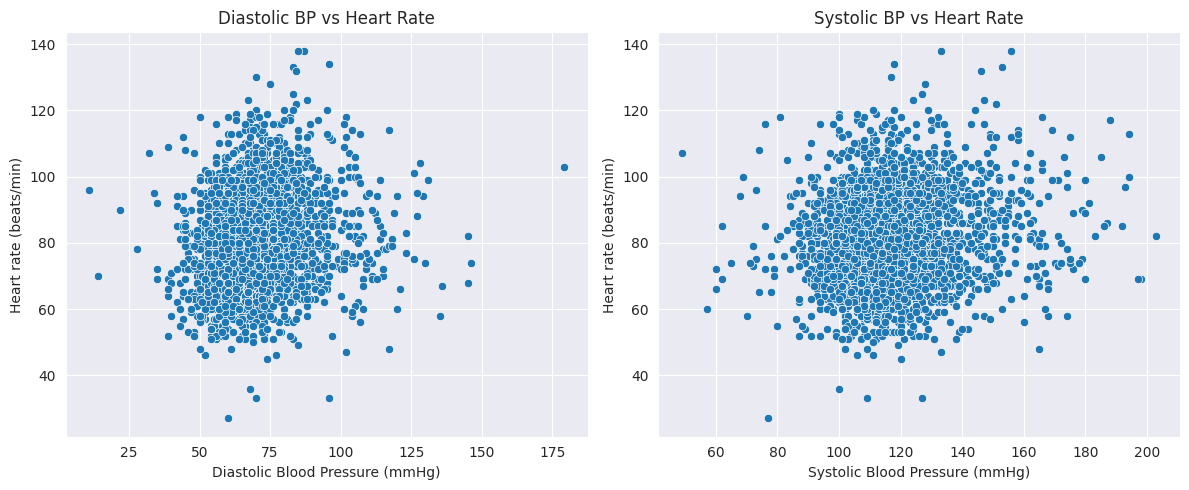

In [359]:
plt.figure(figsize=(12, 5))

# Diastolic BP vs Heart Rate
plt.subplot(1, 2, 1)
sns.scatterplot(x='Physical-Diastolic_BP', y='Physical-HeartRate', data=train_df)
plt.title('Diastolic BP vs Heart Rate')
plt.xlabel('Diastolic Blood Pressure (mmHg)')
plt.ylabel('Heart rate (beats/min)')

# Systolic BP vs Heart Rate
plt.subplot(1, 2, 2)
sns.scatterplot(x='Physical-Systolic_BP', y='Physical-HeartRate', data=train_df)
plt.title('Systolic BP vs Heart Rate')
plt.xlabel('Systolic Blood Pressure (mmHg)')
plt.ylabel('Heart rate (beats/min)')

plt.tight_layout()
plt.show()

In [360]:
calculate_stats(train_df, cols)

,count,mean,std,min,25%,50%,75%,max,missing
Physical-BMI,3022.0,19.331929,5.113934,0.0,15.86935,17.937682,21.571244,59.132048,938
Physical-Height,3027.0,55.946713,7.473764,33.0,50.00000,55.000000,62.000000,78.500000,933
Physical-Weight,3076.0,89.038615,44.569040,0.0,57.20000,77.000000,113.800000,315.000000,884
Physical-Waist_Circumference,898.0,27.278508,5.567287,18.0,23.00000,26.000000,30.000000,50.000000,3062
Physical-Diastolic_BP,2954.0,69.648951,13.611226,0.0,61.00000,68.000000,76.000000,179.000000,1006
Physical-HeartRate,2967.0,81.597236,13.665196,27.0,72.00000,81.000000,90.500000,138.000000,993
Physical-Systolic_BP,2954.0,116.983074,17.061225,0.0,107.00000,114.000000,125.000000,203.000000,1006


* The correlation of fields relating to Physics is quite high
 
**Note:** *The fields in the Physic section have a significant amount of missing values. Some fields, such as `Physical-Waist_Circumference`, may require further processing..*

### 5. FGC và BIA

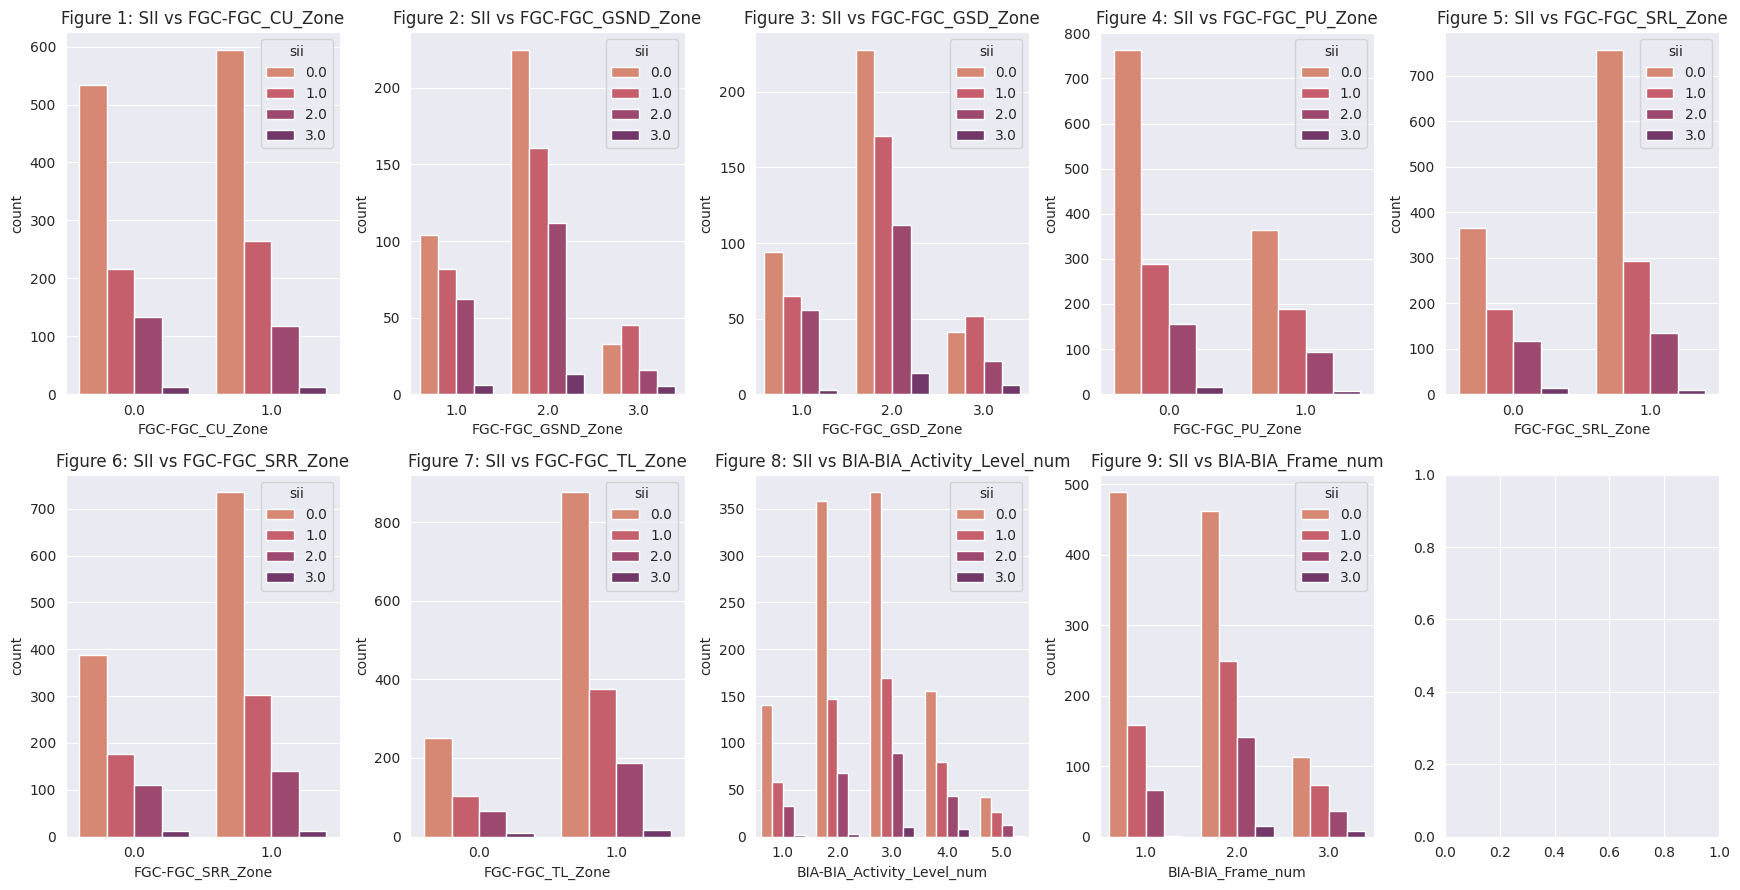

In [361]:
## Categorical feature
cols = ["FGC-FGC_CU_Zone","FGC-FGC_GSND_Zone","FGC-FGC_GSD_Zone","FGC-FGC_PU_Zone","FGC-FGC_SRL_Zone","FGC-FGC_SRR_Zone","FGC-FGC_TL_Zone",
            "BIA-BIA_Activity_Level_num","BIA-BIA_Frame_num"]
n_rows = 2
n_cols = 5

fig, ax = plt.subplots(n_rows, n_cols, figsize = (n_cols * 3.5, n_rows * 4.5))

for r in range(0, n_rows):
    for c in range(0, n_cols):
        i = r*n_cols + c# index to loop through lis cols
        if i < len(cols):
            ax_i = ax[r, c]
            sns.countplot(data = train_df, x = cols[i], hue = "sii", palette = "flare", ax = ax_i)
            ax_i.set_title(f'Figure {i+1}: SII vs {cols[i]}')
plt.tight_layout()
plt.show()


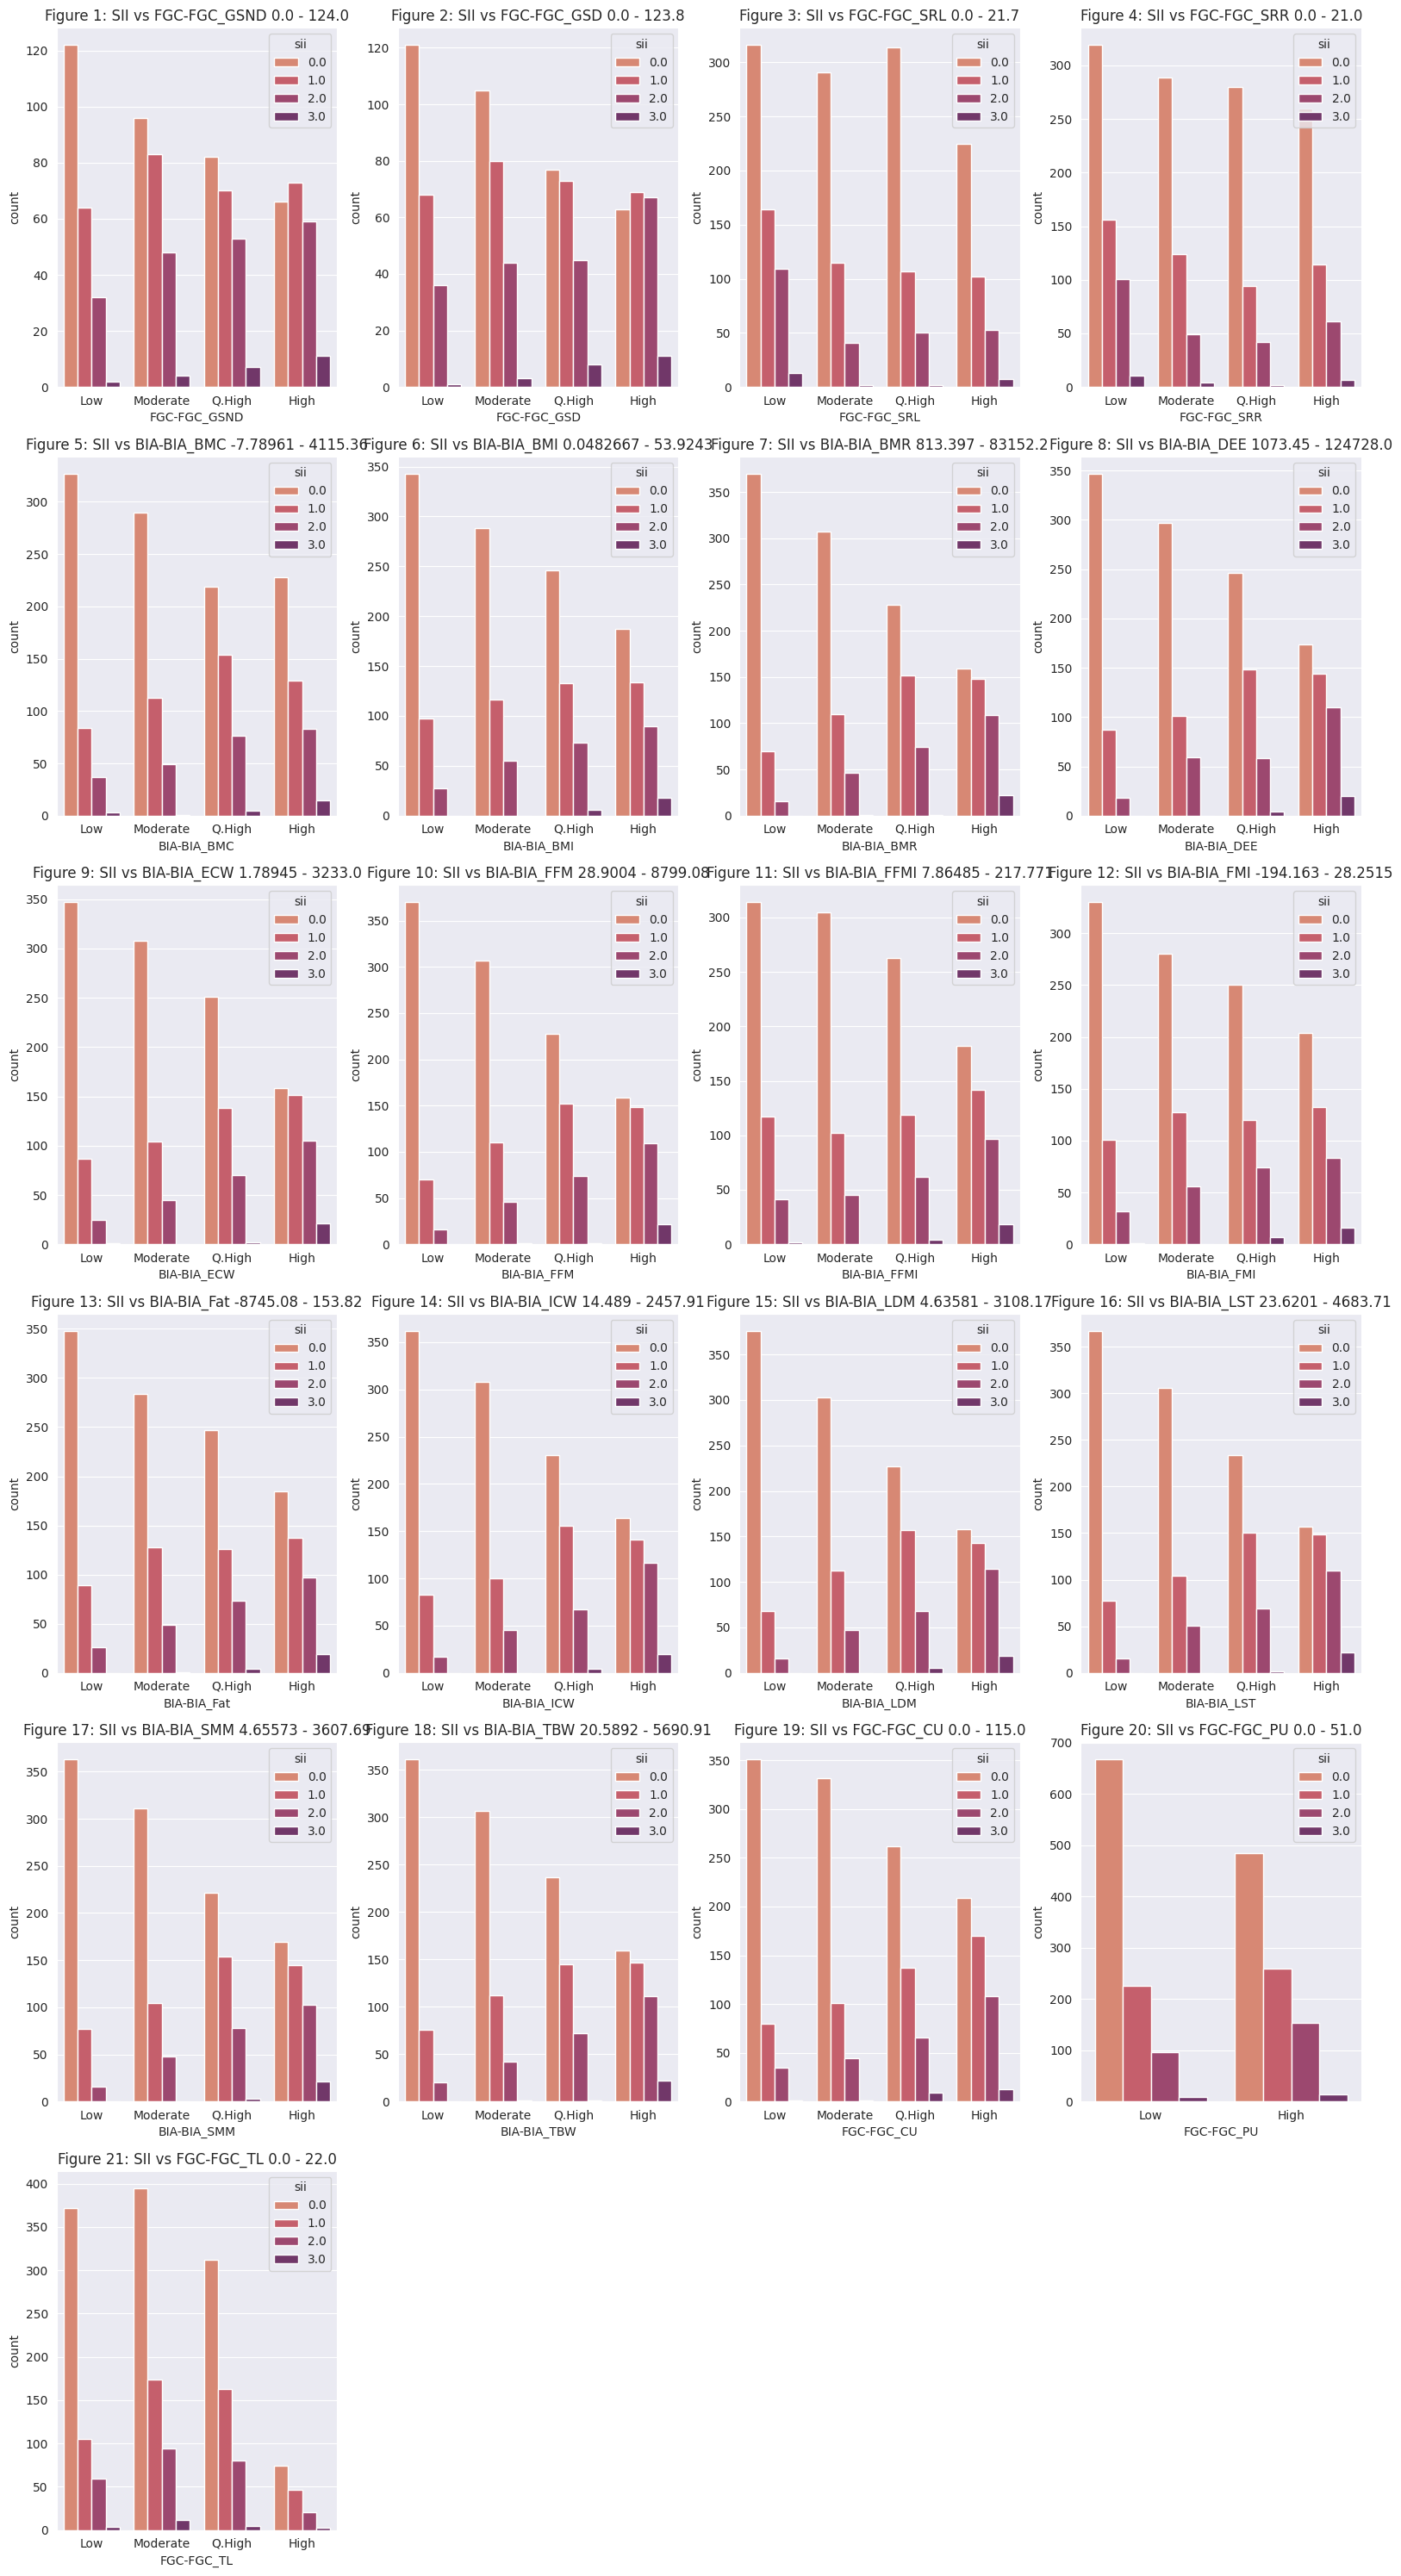

In [362]:
## Numerical features
num_features = ["FGC-FGC_GSND","FGC-FGC_GSD","FGC-FGC_SRL","FGC-FGC_SRR","BIA-BIA_BMC",
           "BIA-BIA_BMI","BIA-BIA_BMR","BIA-BIA_DEE","BIA-BIA_ECW","BIA-BIA_FFM","BIA-BIA_FFMI","BIA-BIA_FMI","BIA-BIA_Fat","BIA-BIA_ICW","BIA-BIA_LDM",
           "BIA-BIA_LST","BIA-BIA_SMM","BIA-BIA_TBW","FGC-FGC_CU","FGC-FGC_PU",
           "FGC-FGC_TL"]
num_categories = ['Low', 'Moderate', 'Q.High', 'High']
n_rows = 6
n_cols = 4

fig, ax = plt.subplots(n_rows, n_cols, figsize = (n_cols * 4, n_rows * 5))

for r in range(0, n_rows):
    for c in range(0, n_cols):
        i = r*n_cols + c# index to loop through lis cols
        if i < len(num_features):
            ax_i = ax[r, c]
            if (num_features[i] == "FGC-FGC_PU"):
                num_categories = ['Low', 'High']
                quartile_data = pd.qcut(train_df[num_features[i]], 2,duplicates = "drop", labels = num_categories )
            else:
                num_categories = ['Low', 'Moderate', 'Q.High', 'High']
                quartile_data = pd.qcut(train_df[num_features[i]], 4, duplicates = "drop", labels = num_categories)
            max_fea = train_df[num_features[i]].max()  # Giá trị lớn nhất
            min_fea = train_df[num_features[i]].min()  # Giá trị nhỏ nhất
            sns.countplot(data = train_df, x = quartile_data, hue = train_df["sii"], palette = "flare", ax = ax_i)
            ax_i.set_title(f'Figure {i+1}: SII vs {num_features[i]} {min_fea} - {max_fea}')
ax.flat[-1].set_visible(False)
ax.flat[-2].set_visible(False)
ax.flat[-3].set_visible(False)


plt.tight_layout()
plt.show()

**Note:**  

*- These charts shows that many fields suc as `FGC-FGC_GSD`, has diverse distributions of `sii` values* 

*- Overall, most fields tend to have higher sii levels as their values increase* 

*- Similar to the fields in Physic, features within the same group (e.g., FGC, BIA) demonstrate relatively high correlation levels*

### 6. Internet Hours

In [363]:
data = train_df[train_df['PreInt_EduHx-computerinternet_hoursday'].notna()]
age_range = data['Basic_Demos-Age']
print(
    f"Age range for participants with measured PreInt_EduHx-computerinternet_hoursday data:"
    f" {age_range.min()} - {age_range.max()} years"
)

Age range for participants with measured PreInt_EduHx-computerinternet_hoursday data: 5.0 - 22.0 years


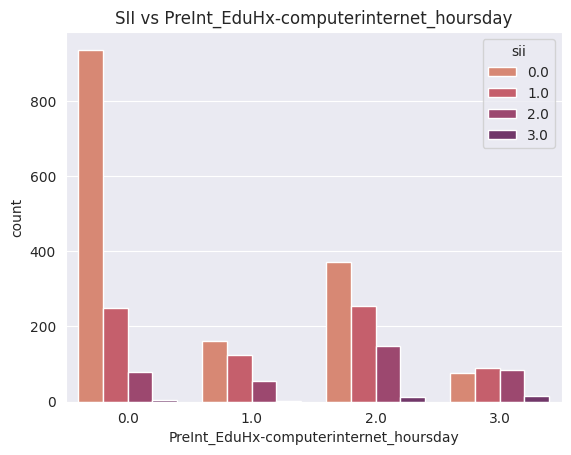

In [364]:
sns.countplot(data=train_df, x='PreInt_EduHx-computerinternet_hoursday', hue='sii', palette='flare')
plt.title("SII vs PreInt_EduHx-computerinternet_hoursday")
plt.show()

# <p style="padding:15px; background-color:#81BFDA; font-family:arial; font-weight:bold; color:white; font-size:100%; letter-spacing: 2px; text-align:left; border-radius: 10px 10px">III. Data Engineering & Wrangling</p>

## Encode Categoricals
- Some models require features to be numerical values; therefore, we need to create functions to convert categorical values into appropriate numerical representations.

In [365]:
category_cols

['Basic_Demos-Sex',
 'FGC-FGC_CU_Zone',
 'FGC-FGC_GSND_Zone',
 'FGC-FGC_GSD_Zone',
 'FGC-FGC_PU_Zone',
 'FGC-FGC_SRL_Zone',
 'FGC-FGC_SRR_Zone',
 'FGC-FGC_TL_Zone',
 'BIA-BIA_Activity_Level_num',
 'BIA-BIA_Frame_num',
 'PCIAT-PCIAT_01',
 'PCIAT-PCIAT_02',
 'PCIAT-PCIAT_03',
 'PCIAT-PCIAT_04',
 'PCIAT-PCIAT_05',
 'PCIAT-PCIAT_06',
 'PCIAT-PCIAT_07',
 'PCIAT-PCIAT_08',
 'PCIAT-PCIAT_09',
 'PCIAT-PCIAT_10',
 'PCIAT-PCIAT_11',
 'PCIAT-PCIAT_12',
 'PCIAT-PCIAT_13',
 'PCIAT-PCIAT_14',
 'PCIAT-PCIAT_15',
 'PCIAT-PCIAT_16',
 'PCIAT-PCIAT_17',
 'PCIAT-PCIAT_18',
 'PCIAT-PCIAT_19',
 'PCIAT-PCIAT_20',
 'Basic_Demos-Enroll_Season',
 'CGAS-Season',
 'Physical-Season',
 'Fitness_Endurance-Season',
 'FGC-Season',
 'BIA-Season',
 'PAQ_A-Season',
 'PAQ_C-Season',
 'PCIAT-Season',
 'SDS-Season',
 'PreInt_EduHx-Season',
 'PreInt_EduHx-computerinternet_hoursday']

In [366]:
#Season encode
season_cols = ['Basic_Demos-Enroll_Season',
             'CGAS-Season',
             'Physical-Season',
             'Fitness_Endurance-Season',
             'FGC-Season',
             'BIA-Season',
             'PAQ_A-Season',
             'PAQ_C-Season',
             'SDS-Season',
             'PreInt_EduHx-Season']

def season_encode(df, season_cols):
    for col in season_cols:
        if col in df.columns:
            df[col] = df[col].astype('object')
            df[col] = df[col].fillna(0)
            df[col] = df[col].replace({'Missing':0, 'Spring':1, 'Summer':2, 'Fall':3, 'Winter':4})
            df[col] = df[col].astype('float64')


def cate_to_float(df, cols):
    for col in cols:
        if col in df.columns:
            df[col] = df[col].astype('float64')

## Data Preprocessing

### 1. PCIAT-PCIAT_Score and sii
- As in the data analyzed, we can notice that these 2 features are quite similar and have the same number of missing value. Therefore, we need to eliminate all the rows containing missing `sii` values to increase the accuracy of ML training model

In [367]:
train_df = train_df.dropna(subset = 'sii')

### 2. CGAS-CGAS_Score
- In the EDA step, we inferred that feature `CGAS-CGAS_Score` has some missing values and some even exceeding the valid range (0-100).

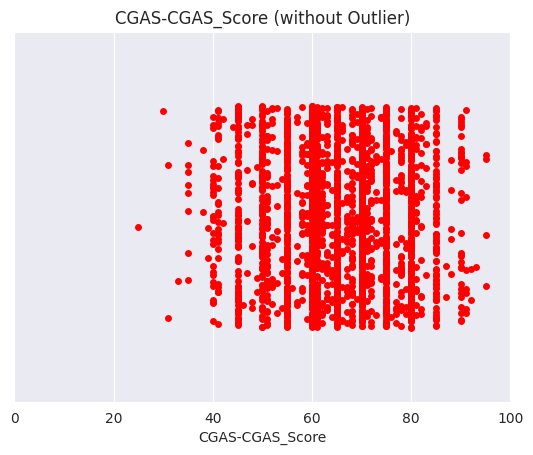

In [368]:
sns.stripplot(data = train_df, x = 'CGAS-CGAS_Score', size= 5, jitter=0.3, color ='red')
plt.title("CGAS-CGAS_Score (without Outlier)")
plt.xlim(0, 100)
plt.show()

- Due to the fact that `CGAS-CGAS_Score` distributes mainly around value 60, we will replace the outliers and null values with the mean value

In [369]:
# train_df
train_df['CGAS-CGAS_Score'] = train_df['CGAS-CGAS_Score'].apply(
    lambda x: x if (0 <= x <= 100) else pd.NA
)

train_df['CGAS-CGAS_Score'].fillna(train_df['CGAS-CGAS_Score'].mean(), inplace=True)

# test_df (điền NaN bằng giá trị trung bình từ train_df)
test_df['CGAS-CGAS_Score'] = test_df['CGAS-CGAS_Score'].apply(
    lambda x: x if (0 <= x <= 100) else pd.NA
)

test_df['CGAS-CGAS_Score'].fillna(train_df['CGAS-CGAS_Score'].mean(), inplace=True)

# Results
train_df['CGAS-CGAS_Score'].describe()

count    2736.000000
mean       65.159266
std        10.927241
min        25.000000
25%        60.000000
50%        65.159266
75%        71.000000
max        95.000000
Name: CGAS-CGAS_Score, dtype: float64

### 3. SEASON
- Features belonging to the season group are categorica`
- Missing values in these features indicate no participation. Therefore, `null` values will be filled with `Missing` (`0`)

In [370]:
## fill missing value for season 

train_df[season_cols] = train_df[season_cols].astype('string').fillna('Missing').astype('category')
test_df[season_cols] = test_df[season_cols].astype('string').fillna('Missing').astype('category')

### 4. Physical-Waist_Circumference

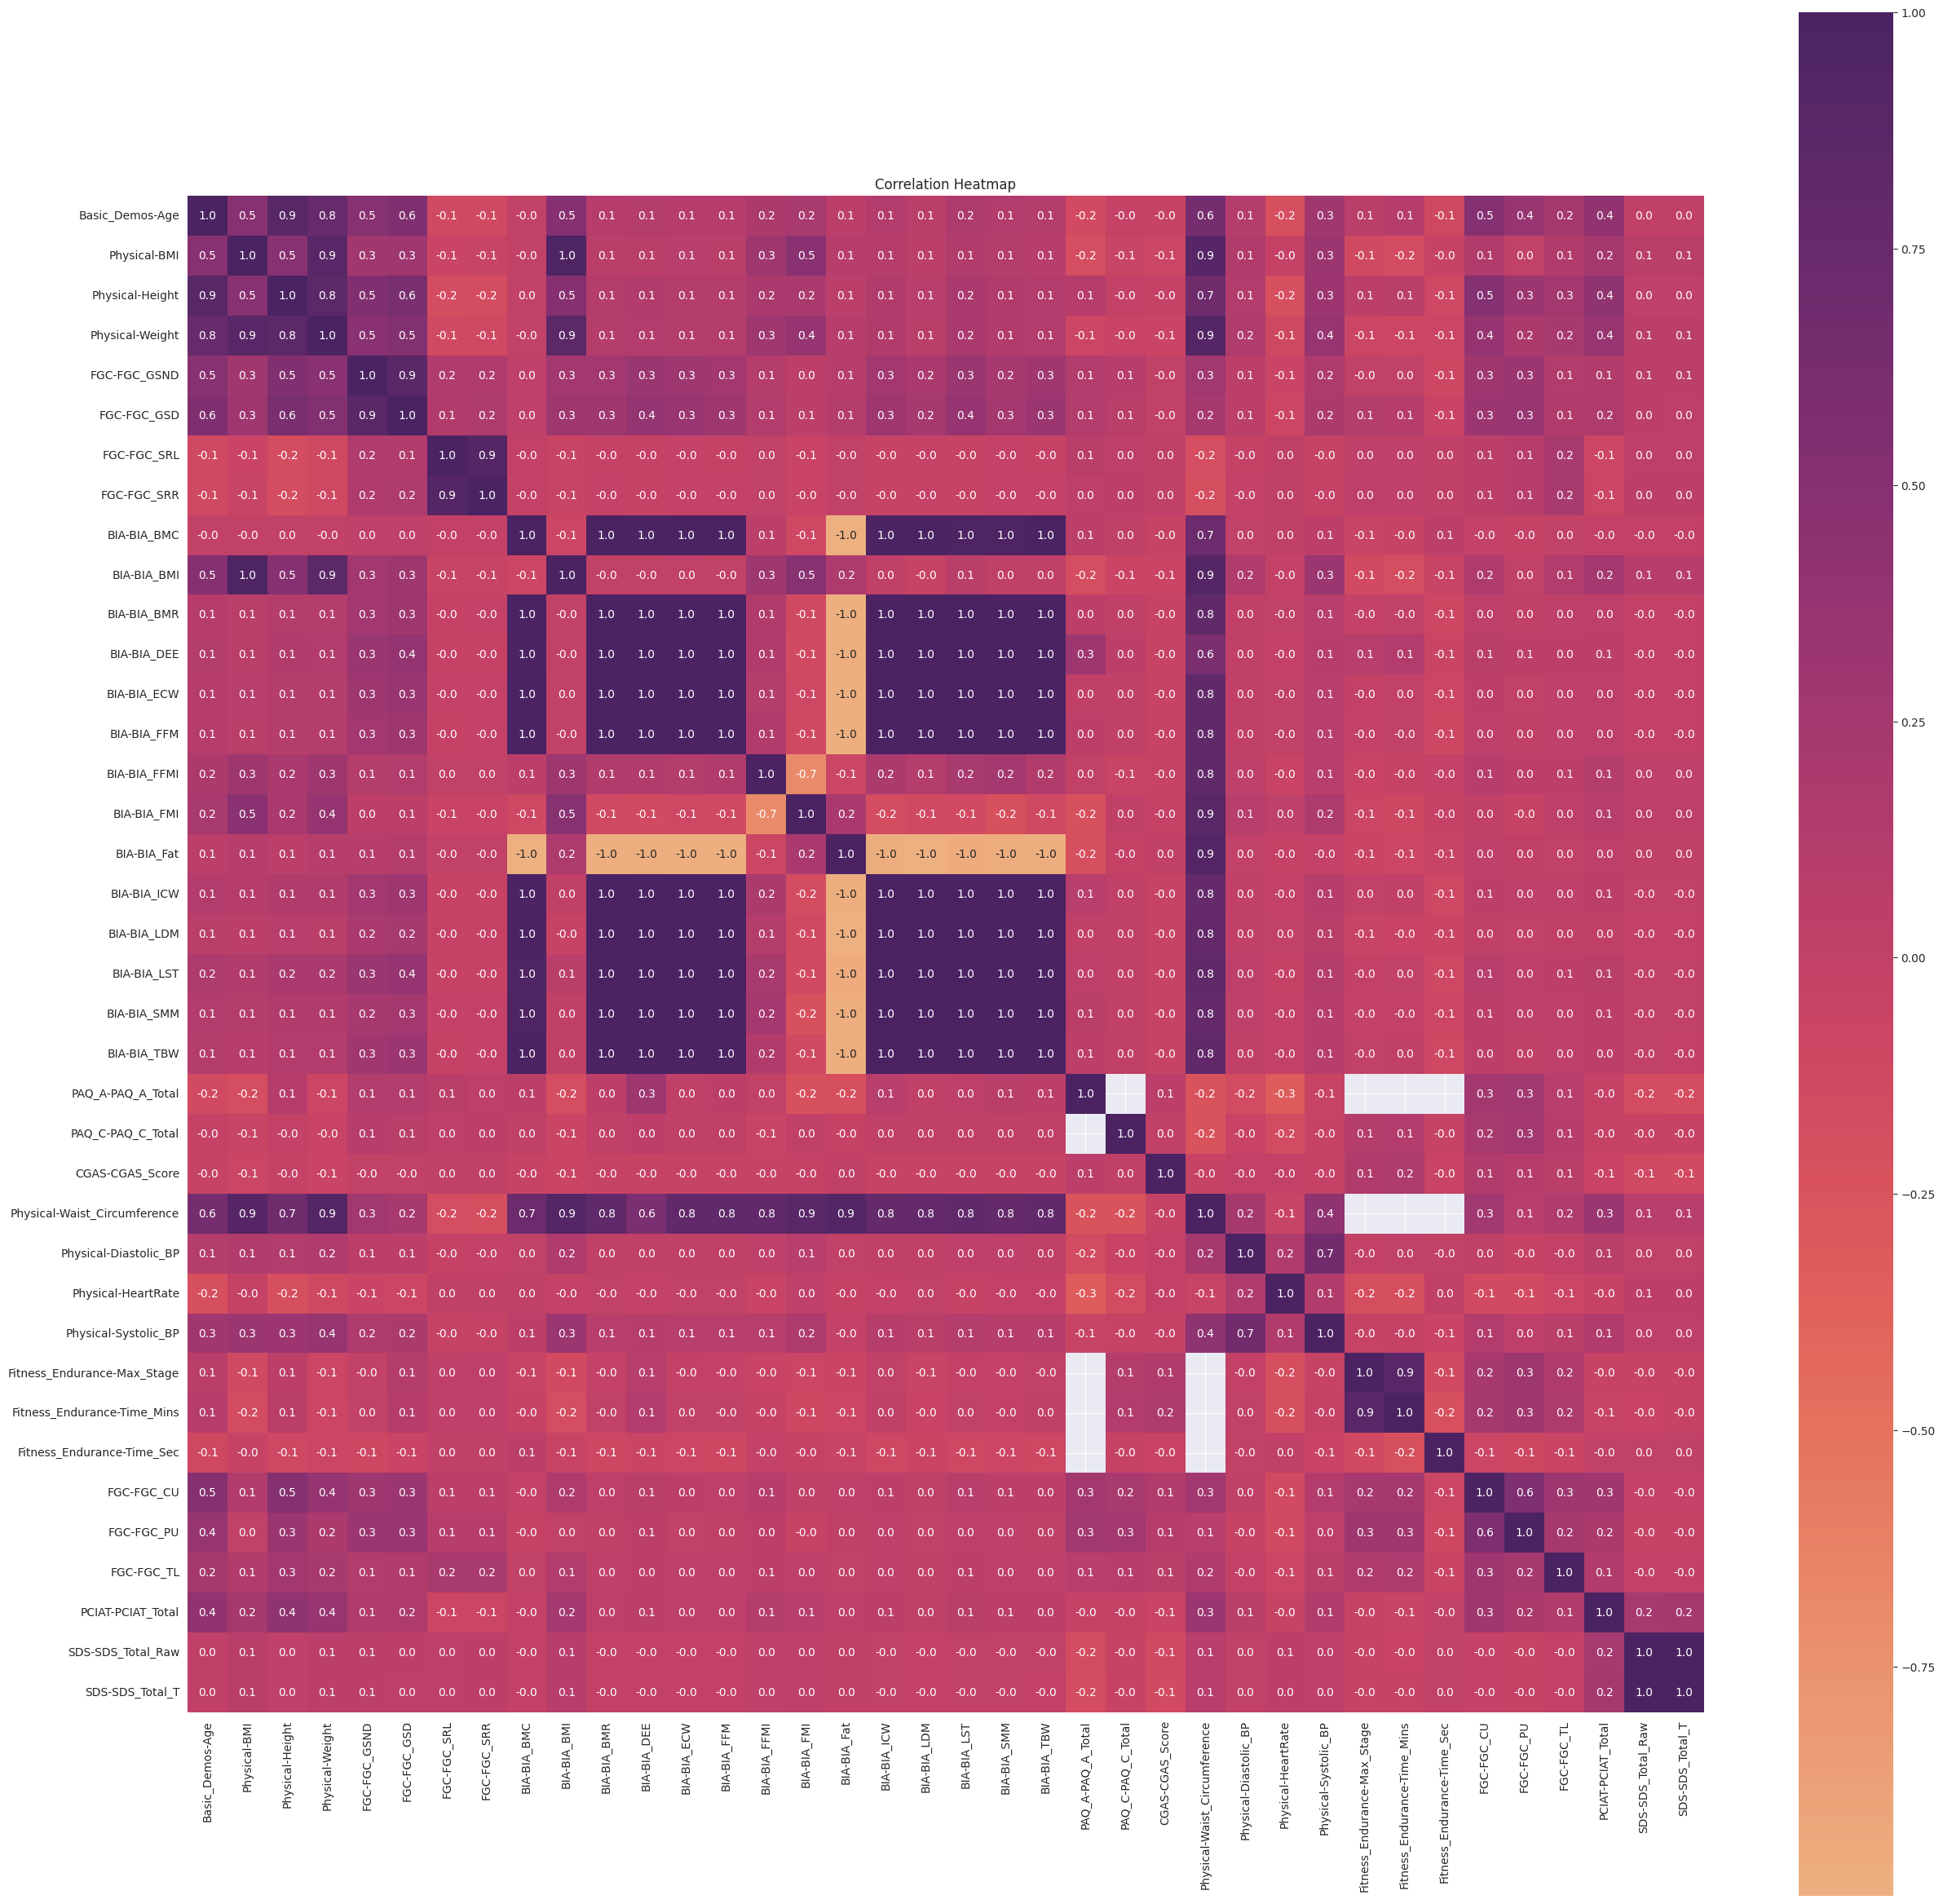

In [371]:
features = ["Age Group", "CGAS_Score_Bin","id","Basic_Demos-Enroll_Season","CGAS-Season","Physical-Season","FGC-Season","BIA-Season","PAQ_A-Season","PAQ_C-Season","PCIAT-Season","SDS-Season","PreInt_EduHx-Season"]

# Drop the 'id' column if present
train_data_no_id = train_df.drop(columns=["Age Group","id"], errors='ignore')
season_cols = [col for col in train_data_no_id.columns if 'Season' in col]
train_data_no_id = train_data_no_id.drop(season_cols, axis=1) 
train_data_no_id = train_df[float_cols]

# Calculate the correlation matrix
correlation_matrix = train_data_no_id.corr()
# Plot the heatmap
plt.figure(figsize=(30, 30))
sns.heatmap(correlation_matrix, annot=True, fmt='.1f', cmap='flare', square=True)
plt.title('Correlation Heatmap')
plt.show()

- From the Correlation Heatmap figure, we can see that most of the features that lost more than 50% of their value have no interaction with other features in train and test.

- Furthermore, from the above chart, we can see that the Waist circumference (in) index is highly correlated with the BIA-BIA index, so although this index has a missing value of up to 82.35%, it can be calculated from a standard Waist circumference formula from BMI, so we will keep this attribute.
Men: A formula based on BMI can be:
Waist circumference=0.74 × BMI + 12.5
Women: Similarly, for women, the formula can be used:
Waist circumference=0.75 × BMI + 13

- Filling feature Physical-Waist_Circumference

In [372]:
def fill_waist_circumference(row):
    if pd.isnull(row['Physical-Waist_Circumference']):  # Checking if Physical-Waist_Circumference columns is missing
        if row['Basic_Demos-Sex'] == 0:
            return 0.74 * row['Physical-BMI'] + 12.5
        elif row['Basic_Demos-Sex'] == 1:
            return 0.75 * row['Physical-BMI'] + 13
    return row['Physical-Waist_Circumference']  # If the values exists, do nothing
train_df['Physical-Waist_Circumference'] = train_df.apply(fill_waist_circumference, axis=1)
test_df['Physical-Waist_Circumference'] = test_df.apply(fill_waist_circumference, axis=1)

### 5. BIA

- After filling Physical Waist_Circumference we can use a KNN method to sort the rows by Physical Waist_Circumference and then fill the missing values by taking the median of the 3 nearest cells. This is a simple K-nearest neighbors (KNN) method, but instead of using a complex algorithm, you will choose to take the median of the rows nearest to Physical Waist_Circumference

In [373]:
def fill_with_median_train(df, bia_bia_prefix='BIA-BIA', waist_column='Physical-Waist_Circumference'):
    # Sort the data by the waist_column column
    df_sorted = df.sort_values(by=waist_column).reset_index(drop=True)

    # A function to calculate the median of the 5 nearest BIA-BIA values based on the waist_column
    def get_median_of_nearest(index, data_waist, data_bia_bia):
        # Determine the range of the nearest values in the waist_column.
        start = max(0, index - 50)
        end = min(len(data_waist), index + 51)
        
        # Filter rows where the BIA-BIA values are not missing.
        nearest_values = data_bia_bia[start:end]
        nearest_waist_values = data_waist[start:end]
        
        # Filter the BIA-BIA values that are not missing
        valid_bia_bia_values = nearest_values[~nearest_values.isna()]
        
        # Check if there are not enough values to calculate the median.
        if len(valid_bia_bia_values) == 0:
            return np.nan  # Return NaN if there are no valid values.
        
        # Calculate the median of the BIA-BIA values that are not missing
        return np.median(valid_bia_bia_values)

    # Fill the NaN values in columns starting with bia_bia_prefix
    for col in df.columns:
        if col.startswith(bia_bia_prefix):
            df[col] = df.apply(
                lambda row: get_median_of_nearest(
                    row.name, df_sorted[waist_column], df_sorted[col]) if pd.isna(row[col]) else row[col], axis=1)

    return df
def fill_with_median_test(df, bia_bia_prefix='BIA-BIA', waist_column='Physical-Waist_Circumference'):
    # Sort the data by the waist_column
    df_sorted = df.sort_values(by=waist_column).reset_index(drop=True)

    # A function to calculate the median of the 5 nearest BIA-BIA values based on the waist_column
    def get_median_of_nearest(index, data_waist, data_bia_bia):
        # Determine the range of the nearest values in the waist_column
        start = max(0, index - 2)
        end = min(len(data_waist), index + 3)
        
        # Filter rows where the BIA-BIA values are not missing
        nearest_values = data_bia_bia[start:end]
        nearest_waist_values = data_waist[start:end]
        
        # Filter the BIA-BIA values that are not missing
        valid_bia_bia_values = nearest_values[~nearest_values.isna()]
        
        # Check if there are not enough values to calculate the median
        if len(valid_bia_bia_values) == 0:
            return np.nan  # Trả về NaN nếu không có giá trị hợp lệ
        
        # Calculate the median of the BIA-BIA values that are not missing
        return np.median(valid_bia_bia_values)

    # Fill the NaN values in the columns starting with bia_bia_prefix
    for col in df.columns:
        if col.startswith(bia_bia_prefix):
            df[col] = df.apply(
                lambda row: get_median_of_nearest(
                    row.name, df_sorted[waist_column], df_sorted[col]) if pd.isna(row[col]) else row[col], axis=1)

    return df
    
train_df = fill_with_median_train(train_df)
test_df = fill_with_median_test(test_df)


## Extension

### 1. CGAS_Hoursday
- It is observed that the questions in PCIAT_PCIAT are related to behaviors and psychological aspects concerning time spent online.
   **For example:** `PCIAT_PCIAT_18` "How often does your child become angry or belligerent when your place time limits on how much time he or shes is allowed to spend online?"

- Based on this observation, we created the feature `CGAS_Hoursday`, which combines `CGAS-CGAS_Score` (indicating psychological state) and `PreInt_EduHx-computerinternet_hoursday` (indicating time spent online)."

In [374]:
train_df['CGAS_Hoursday'] = (train_df['PreInt_EduHx-computerinternet_hoursday'].astype('float64') + 1.25)/train_df['CGAS-CGAS_Score'] 
test_df['CGAS_Hoursday'] =  (test_df['PreInt_EduHx-computerinternet_hoursday'].astype('float64') + 1.25)/test_df['CGAS-CGAS_Score']

- `PreInt_EduHx-computerinternet_hoursday` is incremented to prevent its value from being 0, which would result in 0 when divided by `CGAS-CGAS_Score`.
- The parameter value of 1.25 is adjusted to align with the training model requirements

# <p style="padding:15px; background-color:#81BFDA; font-family:arial; font-weight:bold; color:white; font-size:100%; letter-spacing: 2px; text-align:left; border-radius: 10px 10px">IV. Model</p>


*  Idea: By examining the dataset, we observe a wide variety of features, many of which have over `30%` null values. Additionally, the significance of these features does not clearly indicate a strong relationship with sii and PCIAT-PCIAT_Total. To avoid overfitting and dealing with excessive null values, we decided to use **`XGBoost`** as the training model.
*  During the EDA, we identified a strong correlation between the features `sii` and `PCIAT-PCIAT_Total`, making it feasible to choose either a classification or regression model.
*  Both models will be developed, and we will use **`cross-validation`** to compare the results and select the better-performing model


## 1. Data Filtering

From the data analysis and processing steps, select the data that meets the following criteria
* The missing values of the feature do not exceed 50%.
* The feature has a high correlation with `sii` and `PCIAT-PCIAT_Total`.
* The feature's significance impacts the prediction of the outcome.

### Missing value 

* Filter out features with missing values exceeding 50%

In [375]:
half_missing = [val for val in train_df.columns[train_df.isnull().sum()>len(train_df)/2]]
half_missing

['Fitness_Endurance-Max_Stage',
 'Fitness_Endurance-Time_Mins',
 'Fitness_Endurance-Time_Sec',
 'FGC-FGC_GSND',
 'FGC-FGC_GSND_Zone',
 'FGC-FGC_GSD',
 'FGC-FGC_GSD_Zone',
 'PAQ_A-PAQ_A_Total']

### Correlation
- Create a table sorting the correlation between features and `PCIAT-PCIAT_Total`

In [376]:
season_encode(train_df, season_cols)

ext_float_cols = [
    'PreInt_EduHx-computerinternet_hoursday',
    'FGC-FGC_GSD_Zone',
    'FGC-FGC_GSND_Zone',
    'FGC-FGC_PU_Zone',
    'FGC-FGC_SRL_Zone',
    'FGC-FGC_SRR_Zone',
    'BIA-BIA_Activity_Level_num',
    'BIA-BIA_Frame_num',
    'FGC-FGC_TL_Zone',
    'CGAS_Hoursday'
]

cate_to_float(train_df, ext_float_cols)

corrdata = train_df[float_cols + season_cols + ext_float_cols]
corr = pd.DataFrame(corrdata.corr()['PCIAT-PCIAT_Total'].sort_values(ascending = False))
corr.style.background_gradient(cmap='YlOrRd')

,PCIAT-PCIAT_Total
PCIAT-PCIAT_Total,1.000000
Physical-Height,0.420765
Basic_Demos-Age,0.409559
PreInt_EduHx-computerinternet_hoursday,0.374124
CGAS_Hoursday,0.353146
Physical-Weight,0.353048
FGC-FGC_CU,0.287494
Physical-Waist_Circumference,0.246934
Physical-BMI,0.240858
SDS-SDS_Total_T,0.237718


* Filter features with a correlation greater than 0.2 and cross-check, remove features with more than 50% missing values.

In [377]:
selection = corr[(corr['PCIAT-PCIAT_Total']>.11) | (corr['PCIAT-PCIAT_Total']<-.11)]
selection = [val for val in selection.index]
selection.remove('PCIAT-PCIAT_Total')

## BIA-BIA_BMI and Physical-BMI are similar, choose only one
selection.remove('BIA-BIA_BMI')

selection.remove('SDS-SDS_Total_Raw')

selection = [i for i in selection if i not in half_missing]
selection

['Physical-Height',
 'Basic_Demos-Age',
 'PreInt_EduHx-computerinternet_hoursday',
 'CGAS_Hoursday',
 'Physical-Weight',
 'FGC-FGC_CU',
 'Physical-Waist_Circumference',
 'Physical-BMI',
 'SDS-SDS_Total_T',
 'PAQ_A-Season',
 'FGC-FGC_PU',
 'Physical-Systolic_BP',
 'BIA-BIA_Frame_num',
 'FGC-FGC_TL',
 'PAQ_C-Season',
 'FGC-FGC_SRL_Zone']

### Meaning 

* In the PCIAT-PCIAT questions, there are several items addressing how internet use affects physical activity time.
     Ex: `PCIAT-PCIAT_11`, 'PCIAT-PCIAT_14`

* In reality, spending excessive time on the internet can impact several aspects of health as follows:
 

     - Reduced mobility.

     - The spine is affected due to prolonged sitting.

     - Stamina and flexibility are generally low.

From the above observations, we can consider certain `FitnessGram` features that may influence predictions:
* `FGC-FGC_TL_Zone` represents the ability to perform a prone trunk lift.,
* `FGC-FGC_SRR_Zone` represents the ability to perform a right-sided sit-and-reach.
* Both metrics reflect the flexibility of the body and the spine, making them relevant features to include in the training process.

In [378]:
selection += ['FGC-FGC_TL_Zone','FGC-FGC_SRR_Zone']

### Final features

In [379]:
selection

['Physical-Height',
 'Basic_Demos-Age',
 'PreInt_EduHx-computerinternet_hoursday',
 'CGAS_Hoursday',
 'Physical-Weight',
 'FGC-FGC_CU',
 'Physical-Waist_Circumference',
 'Physical-BMI',
 'SDS-SDS_Total_T',
 'PAQ_A-Season',
 'FGC-FGC_PU',
 'Physical-Systolic_BP',
 'BIA-BIA_Frame_num',
 'FGC-FGC_TL',
 'PAQ_C-Season',
 'FGC-FGC_SRL_Zone',
 'FGC-FGC_TL_Zone',
 'FGC-FGC_SRR_Zone']

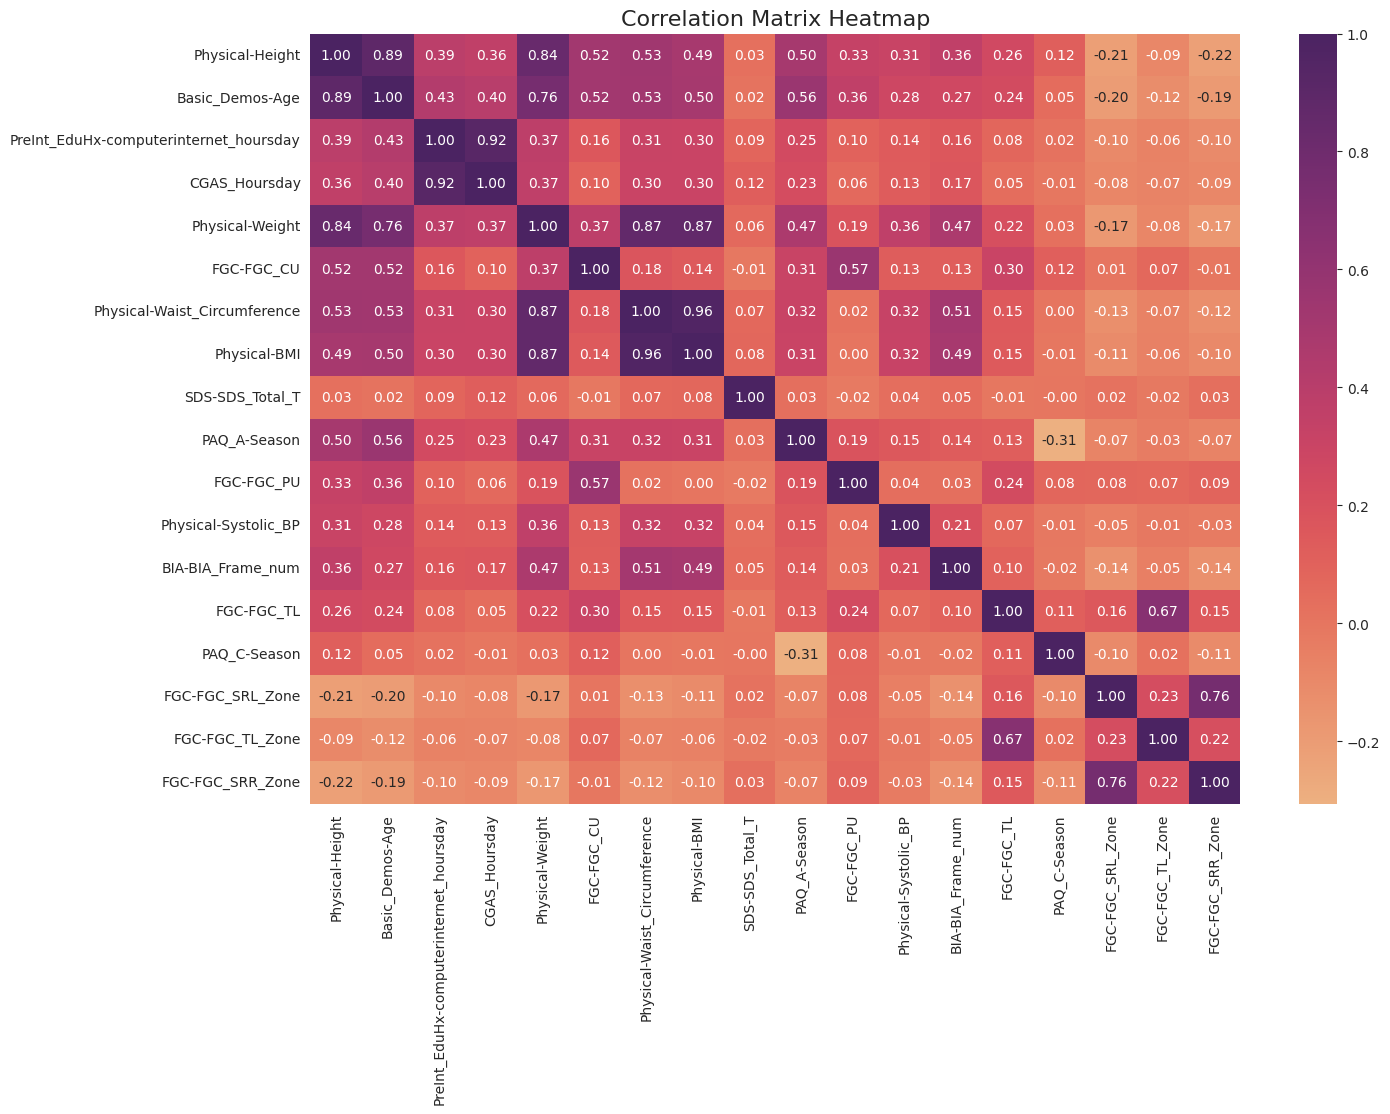

In [380]:
columns_to_include = selection + ['PCIAT-PCIAT_Total', 'sii']
correlation_matrix = train_df[selection].corr()
    
# Drawing heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='flare', cbar=True)
plt.title(f"Correlation Matrix Heatmap", fontsize=16)
plt.show()

## 2. Building the ML MODEL

In [381]:
X = train_df[selection]
y = train_df['sii']

test = test_df[selection]

In [382]:
def quadratic_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')
kappa_scorer = make_scorer(quadratic_kappa)

### Classification model approach

In [383]:
params = {
    'max_depth': 3, 
    'n_estimators': 202,
    'learning_rate': 0.07956777025142073, 
    'subsample': 0.8197358255094112, 
    'colsample_bytree': 0.645036755035947
}
skf = StratifiedKFold(n_splits=10)
clf = xgb.XGBClassifier(**params)


ext_float_cols = [
    'PreInt_EduHx-computerinternet_hoursday',
    'FGC-FGC_GSD_Zone',
    'FGC-FGC_GSND_Zone',
    'FGC-FGC_PU_Zone',
    'FGC-FGC_SRL_Zone',
    'FGC-FGC_SRR_Zone',
    'BIA-BIA_Activity_Level_num',
    'BIA-BIA_Frame_num',
    'FGC-FGC_TL_Zone',
    'CGAS_Hoursday'
]

cate_to_float(train_df, ext_float_cols)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2736 entries, 0 to 3958
Data columns (total 85 columns):
 #   Column                                  Non-Null Count  Dtype   
---  ------                                  --------------  -----   
 0   id                                      2736 non-null   string  
 1   Basic_Demos-Enroll_Season               2736 non-null   float64 
 2   Basic_Demos-Age                         2736 non-null   float64 
 3   Basic_Demos-Sex                         2736 non-null   category
 4   CGAS-Season                             2736 non-null   float64 
 5   CGAS-CGAS_Score                         2736 non-null   float64 
 6   Physical-Season                         2736 non-null   float64 
 7   Physical-BMI                            2527 non-null   float64 
 8   Physical-Height                         2530 non-null   float64 
 9   Physical-Weight                         2572 non-null   float64 
 10  Physical-Waist_Circumference            2528 non-null

In [384]:
scores = cross_val_score(clf, X, y, cv=skf, scoring=kappa_scorer, error_score='raise')
print("QWK Scores:", scores)
print("Mean QWK Score:", np.mean(scores))

QWK Scores: [0.29542197 0.33699652 0.43908897 0.3630149  0.39106391 0.31024487
 0.39296543 0.42935387 0.31724846 0.36426456]
Mean QWK Score: 0.36396634631577623


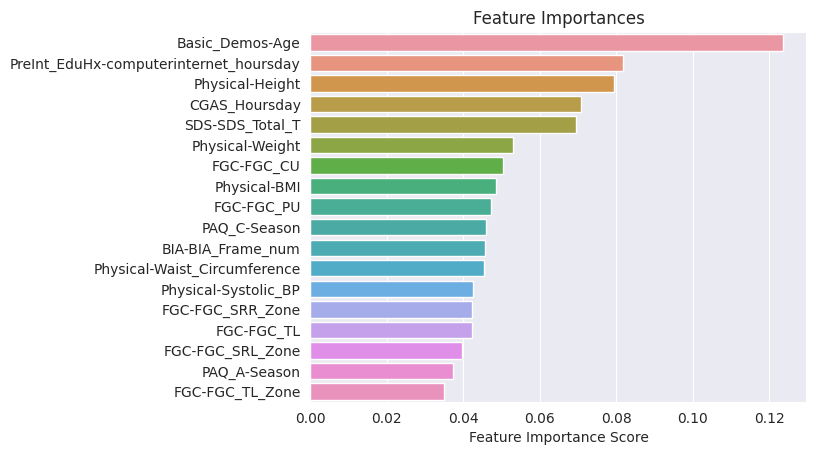

In [385]:
clf.fit(X,y)
feature_imp = pd.Series(clf.feature_importances_,index=X.columns).sort_values(ascending=False)
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.title("Feature Importances")
plt.show()

In [386]:
preds = clf.predict(test)
print(preds)

[2 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0]


### Regression Model Approach

In [387]:
y = train_df['PCIAT-PCIAT_Total']

In [388]:
def convert(scores):
    scores = np.array(scores) * 1.25342583
    bins = np.zeros_like(scores)
    bins[scores <= 30] = 0
    bins[(scores > 30) & (scores < 50)] = 1
    bins[(scores >= 50) & (scores < 80)] = 2
    bins[scores >= 80] = 3
    return bins

- The parameter `1.2536183` is calibrated to yield optimal results.

In [389]:
def quadratic_kappa(y_true, y_pred):
    y_true_cat = convert(y_true)
    y_pred_cat = convert(y_pred)
    return cohen_kappa_score(y_true_cat, y_pred_cat, weights='quadratic')

kappa_scorer = make_scorer(quadratic_kappa, greater_is_better=True)

In [390]:
params = {'max_depth': 3, 
          'n_estimators': 59, 
          'learning_rate': 0.07327652118259573, 
          'subsample': 0.5968194045365575, 
          'colsample_bytree': 0.9123669348125403
         }
model = xgb.XGBRegressor(**params)

In [391]:
scores = cross_val_score(model, X, y, cv=skf, scoring=kappa_scorer)
print("QWK Scores:", scores)
print("Mean QWK Score:", np.mean(scores))

QWK Scores: [0.39495437 0.48010673 0.51735626 0.43144048 0.47438151 0.42031385
 0.46113208 0.41290323 0.47543796 0.48663319]
Mean QWK Score: 0.4554659649260378


In [392]:
model.fit(X,y)
feature_imp = pd.Series(model.feature_importances_,index=X.columns).sort_values(ascending=False)
feature_imp

Basic_Demos-Age                           0.213300
PreInt_EduHx-computerinternet_hoursday    0.098121
Physical-Height                           0.084625
CGAS_Hoursday                             0.071636
SDS-SDS_Total_T                           0.063213
FGC-FGC_CU                                0.062093
FGC-FGC_TL_Zone                           0.050131
Physical-Weight                           0.049561
FGC-FGC_PU                                0.045862
PAQ_C-Season                              0.038088
PAQ_A-Season                              0.037966
FGC-FGC_TL                                0.032467
FGC-FGC_SRL_Zone                          0.028735
Physical-Systolic_BP                      0.028610
Physical-Waist_Circumference              0.027437
Physical-BMI                              0.027425
BIA-BIA_Frame_num                         0.021236
FGC-FGC_SRR_Zone                          0.019496
dtype: float32

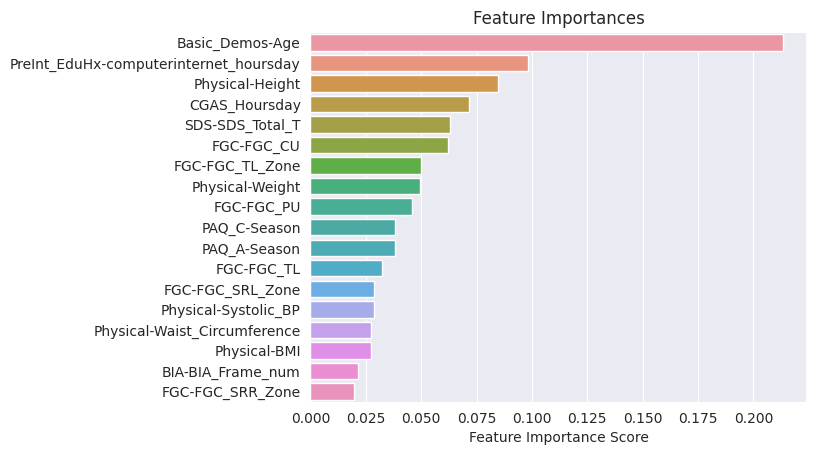

In [393]:
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.title("Feature Importances")
plt.show()

 # <p style="padding:15px; background-color:#81BFDA; font-family:arial; font-weight:bold; color:white; font-size:100%; letter-spacing: 2px; text-align:left; border-radius: 10px 10px">V. Conclusion</p>
- **Based on the correlation matrix, it can be observed that the correlation of the parameters with `PCIAT-PCIAT_Total` is stronger. Additionally, the cross-validation results of the regression model outperform those of the classification model. Therefore, we choose the XGBoost Regressor model for prediction.**

In [394]:
model.fit(X,y)
preds = model.predict(test)
preds = convert(preds) # convert raw scores to sii categories if using regressor
preds = pd.Series(preds)

In [395]:
Submission = pd.DataFrame({
    'id': sample['id'],
    'sii': preds
})
Submission.to_csv('submission.csv', index=False)
print(Submission['sii'].value_counts())

sii
1.0    17
0.0     3
Name: count, dtype: int64
